In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import Hold,PeriodicRebalance

plotdir = '../portfolio/plots/'
datadir= '../equity_data_tool/'

## Download data using ee103 code (to be integrated) 

In [2]:
sigmas=pd.read_csv(datadir+'sigmas.txt',index_col=0,parse_dates=[0])
returns=pd.read_csv(datadir+'returns.txt',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.txt',index_col=0,parse_dates=[0])
#prices=pd.read_csv(datadir+'prices.txt',index_col=0,parse_dates=[0])

spread = pd.DataFrame(data=2.5*1e-4, index=volumes.index, columns=volumes.columns)
nonlin_coeff = pd.DataFrame(data=1, index=volumes.index, columns=volumes.columns) # fix volatility model

## Simulations

In [3]:
import pandas as pd

from cvx_portfolio.costs import TcostModel
from cvx_portfolio.simulator import MarketSimulator
from cvx_portfolio.policies import Hold,PeriodicRebalance

simulated_tcost = TcostModel(volumes, sigmas, spread, nonlin_coeff, cash_key='USDOLLAR')
simulator = MarketSimulator(returns, volumes, [simulated_tcost], cash_key='USDOLLAR')

benchmark = pd.Series(index=returns.columns, data=1)/len(returns.columns)
benchmark/=sum(benchmark)

def select_starts_periods(period_property, timestamps):
    selected = [timestamps[0]]
    for day in timestamps[1:]:
        if not (period_property(day) == period_property(selected[-1])):
            selected.append(day)
    return selected

policies = []
for selector in [lambda t: t.day,lambda t: t.week,lambda t: t.month,lambda t: t.quarter,lambda t: t.year]:
    policies.append(PeriodicRebalance(target=benchmark, rebalancing_times=select_starts_periods(selector,
                                                                                                returns.index)))
policies.append(Hold())

res = pd.DataFrame(index=['D','W','M','Q','A','H'])
for label, fund_val in [('\$100M',1E8), ('\$10B',1E10)]:
    res[label] = simulator.run_multiple_backtest(fund_val*benchmark, start_time="2012-01-01", 
                                     end_time="2016-12-31", policies=policies)

## Results 

In [4]:
avg_daily_return=lambda res: 10000*(res.mean_return)/250
total_tcost=lambda res: (res.simulator_TcostModel.sum(1)).sum() / 1E6
avg_daily_tcost=lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 10000
RMSE = lambda res: np.sqrt(np.mean((returns.loc[returns.index>'2012-01-01'].mean(1) - res.returns)**2))*10000
final_val = lambda res: res.v[-1]/1E9

table=pd.DataFrame({r'$\bar R^p$':res.applymap(avg_daily_return).unstack(),
              r'$\|R^\mathrm{p}_t - R^\mathrm{b}_t\|/\sqrt{T}$' :res.applymap(RMSE).unstack(),
              r'$\sum_t  \phi^\text{trade}_t (u_t)$':res.applymap(total_tcost).unstack(), 
              r'$\sum_t \phi_t^\text{trade} (z_t) / T$':res.applymap(avg_daily_tcost).unstack(),
             })
table.ix[:,1]=table.ix[:,1].apply(lambda x: r'\$%.2fM'%x )
table

$\bar R^p$ $\sum_t  \phi^\text{trade}_t (u_t)$  \
\$100M D    6.713017                             \$0.70M   
       W    6.734891                             \$0.39M   
       M    6.738698                             \$0.24M   
       Q    6.768740                             \$0.16M   
       A    6.768510                             \$0.09M   
       H    6.794070                             \$0.00M   
\$10B  D    6.599715                           \$306.42M   
       W    6.656869                           \$203.06M   
       M    6.681390                           \$145.92M   
       Q    6.725762                           \$109.43M   
       A    6.744920                            \$68.76M   
       H    6.794070                             \$0.00M   

          $\sum_t \phi_t^\text{trade} (z_t) / T$  \
\$100M D                                0.033232   
       W                                0.018597   
       M                                0.011394   
       Q                                0.007757   
       A                                0.004237   
       H                                0.000000   
\$10B  D                                0.145634   
       W                                0.096326   
       M                                0.069069   
       Q                                0.051859   
       A                                0.031667   
       H                                0.000000   

          $\|R^\mathrm{p}_t - R^\mathrm{b}_t\|/\sqrt{T}$  
\$100M D                                        0.035779  
       W                                        0.546420  
       M                                        1.257383  
       Q                                        2.199362  
       A                                        4.572540  
       H                                       12.809316  
\$10B  D                                        0.167891  
       W                                        0.594704  
       M                                        1.301684  
       Q                                        2.237234  
       A                                        4.603367  
       H                                       12.809316

In [5]:
print(table.to_latex(float_format='%.2f', escape=False))

\begin{tabular}{llrlrr}
\toprule
       &   &  $\bar R^p$ & $\sum_t  \phi^\text{trade}_t (u_t)$ &  $\sum_t \phi_t^\text{trade} (z_t) / T$ &  $\|R^\mathrm{p}_t - R^\mathrm{b}_t\|/\sqrt{T}$ \\
\midrule
\$100M & D &        6.71 &                             \$0.70M &                                    0.03 &                                            0.04 \\
       & W &        6.73 &                             \$0.39M &                                    0.02 &                                            0.55 \\
       & M &        6.74 &                             \$0.24M &                                    0.01 &                                            1.26 \\
       & Q &        6.77 &                             \$0.16M &                                    0.01 &                                            2.20 \\
       & A &        6.77 &                             \$0.09M &                                    0.00 &                                            4.57 \\
       & H

# Plots 

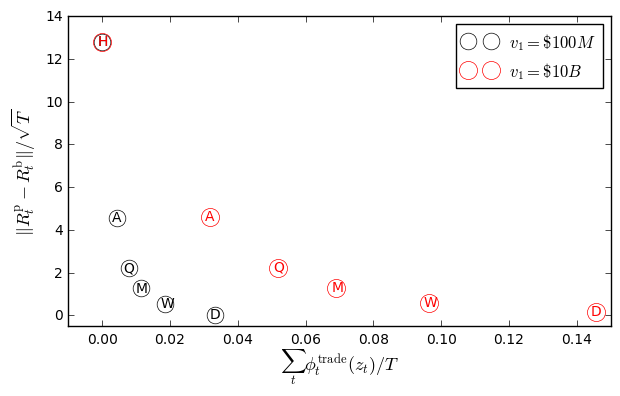

In [6]:
plt.figure(figsize=(7,4))
colors=['k','r']
offsetx = 0.0015
offsety = 0.15
data=table.ix[:,2:]

for j,initval in enumerate(data.index.levels[0]):
    x=data.loc[initval].ix[:,0].values
    y=data.loc[initval].ix[:,1].values
    line,=plt.plot(x,y, colors[j]+'o', 
                   markersize=12+j,
                   fillstyle='none', 
                   label='$v_1 = %s$'%initval)
    for i in range(len(x)):
        plt.text(x[i]-offsetx,y[i]-offsety, data.index.levels[1][i],color=colors[j] )


plt.legend(loc='upper right')
plt.xlabel(r'$\sum_t \phi_t^{\mathrm{trade}}(z_t)/T$',fontsize=13)
ax = plt.gca()
ax.xaxis.set_label_coords(.5, -0.065)

plt.ylabel(r'$\|R^\mathrm{p}_t - R^\mathrm{b}_t\|/\sqrt{T}$',fontsize=13)
plt.xlim([-0.01,0.15])
plt.ylim([- 0.5, 14])
plt.savefig(plotdir+'basic_frontier.png')

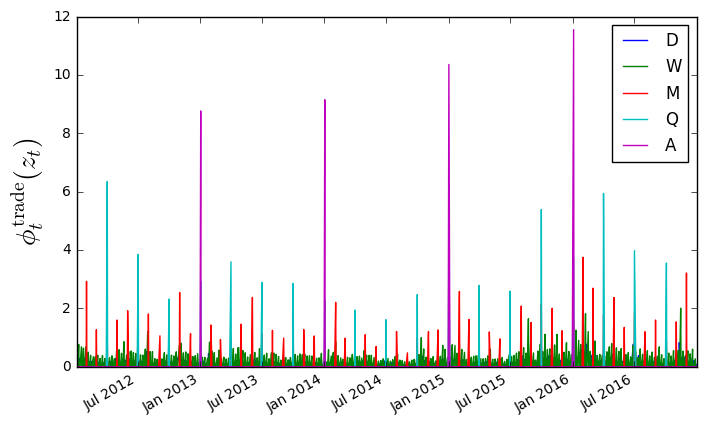

In [7]:
res.loc[:, '\$10B'].apply(lambda x: 10000*x.simulator_TcostModel.sum(1)/x.v).T.ix[:,:-1].plot(figsize=(8,5))
plt.ylabel("$\phi_t^{\mathrm{trade}}(z_t)$",fontsize=20)
plt.savefig(plotdir+'basic_example_tcost_time.png')

In [9]:
# for k,results in res.loc['D'].iteritems():
#     plt.figure()
#     (100*(results.v-results.initial_val)/results.initial_val).plot(label='Profit (%)')
#     (100*(-results.simulator_TcostModel.sum(1).cumsum())/results.initial_val).plot(style='r',label='T. costs (%)')
#     plt.legend(loc='upper left')
#     plt.title('%s uniform portfolio daily rebalance simulation'%k)
#     plt.savefig(plotdir+'%s_pandl_tcost_tseries.png'%k[1:])